# TP Reconnaissance
## Pré-requis
On a besoin du dossier *PositionHandJoints* dans le même répertoire que ce Jupyter Notebook. <br>
J'ai choisit de traiter les mains gauches et droites de manière différente et de comparer les resultats des données de l'un sur le modele de l'autre.<br>
Au debut je traitait les 2 mains en même temps mais les réponses des algorithmes n'était pas précise ayant une accuracy d'environ 0.6.
## Import

In [1]:
import numpy as np
import time
import glob
import csv
import pandas as pd
import sklearn.metrics as m
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


## Recuperation Données

In [2]:
def read_csv_file(_file_name):
    df=pd.read_csv(_file_name, sep=',', header=None)
    return df.values

## Trouve les fichiers et leurs noms

In [3]:
def init_data_file(hand_='LH', sequence_=None, frame_=None, label_=None):
    data = {hand_ : [{},{},{},{},{},{},{},{},{},{},{}] }
    for name in glob.glob('PositionHandjoints/*'):
        name_file = name.split('\\')[1]
        elems = name_file.split('_')

        d_type = elems[0]
        if hand_ == d_type:
            sequence =  elems[1].split('S')[1]
            if sequence_ == None or sequence_ == sequence:
                frame = elems[2].split('f')[1]
                if frame_ == None or frame_ == frame:
                    length = elems[3].split('l')[1]
                    label = elems[4].split('.')[0]
                    if label_ == None or label_ == label:
                        data[str(d_type)][int(sequence)-1].update({int(frame) : [int(length),label]})
    return data

## Lecture de tous les csv et stockage dans un tableau par main

In [4]:
def read_all_files(hand_='LH', sequence_=None, frame_=None, label_=None):
    alldata_file = init_data_file(hand_, sequence_, frame_,label_)
    data = []
    cible = []
    nb_classe_cible = 0
    
    for key,values in alldata_file.items():
        sequence_max = len(values)-1
        for seq in range(sequence_max):
            for key2 in values[seq].keys():
                filename = 'PositionHandJoints/'+ key + '_S' + "%s" % (seq+1) + '_f' + "%s" % key2 + '_l' + "%s" % values[seq][key2][0] + '_' + values[seq][key2][1] + '.csv'
                table = pd.read_csv(filename, sep=' ',header=None)

                val = table.values
                m,d = val.shape
                cible_tmp = [int(nb_classe_cible) for i in range(m)]
                for i in range(m):
                    if i > 0 :
                        cible.append(cible_tmp[i])
                        data_tmp = []
                        for j in range(d-1):
                            data_tmp.append(float(val[i][j])) 
                        data.append(data_tmp)
                nb_classe_cible += 1
    return np.asarray(data),np.asarray(cible), nb_classe_cible

In [5]:
data_left, target_left, nb_left = read_all_files(hand_='LH')
print('Nombre de classes de la main gauche :', nb_left)

data_right, target_right, nb_right = read_all_files(hand_='RH')
print('Nombre de classes de la main droite :', nb_right)

Nombre de classes de la main gauche : 223
Nombre de classes de la main droite : 377


## Statistiques

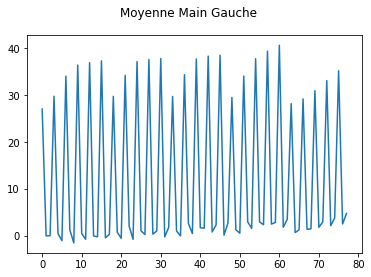

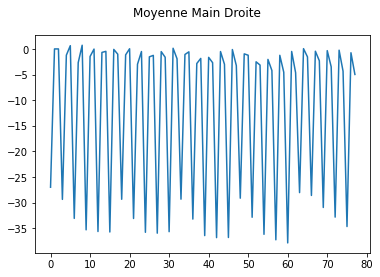

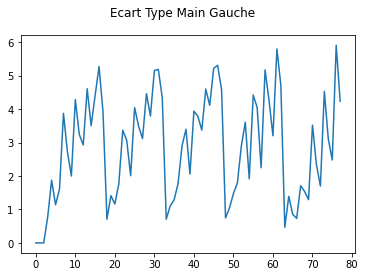

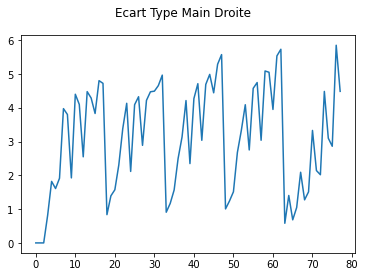

indice  9  plus petit ecart type left :  [ 0  1  2 63 18 33 66 48  3]
indice  9  plus petit ecart type right :  [ 0  1  2 63 65  3 18 33 48]


In [6]:
mean_left = np.mean(data_left, axis=0)
fig = plt.figure()
fig.suptitle('Moyenne Main Gauche')
plt.plot(np.arange(mean_left.shape[0]),mean_left)
plt.show()

mean_right = np.mean(data_right, axis=0)
fig = plt.figure()
fig.suptitle('Moyenne Main Droite')
plt.plot(np.arange(mean_right.shape[0]),mean_right)
plt.show()

std_left = np.std(data_left, axis=0)
fig = plt.figure()
fig.suptitle('Ecart Type Main Gauche')
plt.plot(np.arange(std_left.shape[0]),std_left)
plt.show()

std_right = np.std(data_right, axis=0)
fig = plt.figure()
fig.suptitle('Ecart Type Main Droite')
plt.plot(np.arange(std_right.shape[0]),std_right)
plt.show()

k=9
indice_k_plus_petite_variation_left = np.argsort(std_left)[:k]
print('indice ',k,' plus petit ecart type left : ', indice_k_plus_petite_variation_left)
indice_k_plus_petite_variation_right = np.argsort(std_right)[:k]
print('indice ',k,' plus petit ecart type right : ', indice_k_plus_petite_variation_right)

## Separation data
### Gauche

In [7]:
X_train_left, X_test_left, y_train_left, y_test_left = train_test_split(data_left, target_left, test_size=0.2)
X_train_left = np.asarray(X_train_left)
X_test_left = np.asarray(X_test_left)

### Droite

In [8]:
X_train_right, X_test_right, y_train_right, y_test_right = train_test_split(data_right, target_right, test_size=0.2)
X_train_right = np.asarray(X_train_right)
X_test_right = np.asarray(X_test_right)

## SVC
### Gauche

In [9]:
svc_l_time = time.time()
svc_l = SVC(gamma='auto')
svc_l.fit(X_train_left, y_train_left)
svc_l_score = svc_l.score(X_test_left, y_test_left)
svc_l_time = time.time() - svc_l_time
svc_l_score

0.9642177388656262

### Droite

In [10]:
svc_r_time = time.time()
svc_r = SVC(gamma='auto')
svc_r.fit(X_train_right, y_train_right)
svc_r_score = svc_r.score(X_test_right, y_test_right)
svc_r_time = time.time() - svc_r_time
svc_r_score

0.9266195885784464

### Main Inverse

In [11]:
print('Accuracy modele main droite données tests main gauche : ', svc_r.score(X_test_left, y_test_left))
print('Accuracy modele main gauche données tests main droite : ', svc_l.score(X_test_right, y_test_right))

Accuracy modele main droite données tests main gauche :  0.0
Accuracy modele main gauche données tests main droite :  0.00092109303039607


## Gaussian
### Gauche

In [12]:
gnb_l_time = time.time()
gnb_l = GaussianNB()
gnb_l.fit(X_train_left, y_train_left)
gnb_l_score = gnb_l.score(X_test_left, y_test_left)
gnb_l_time = time.time() - gnb_l_time
gnb_l_score

0.7902550437761705

### Droite

In [13]:
gnb_r_time = time.time()
gnb_r = GaussianNB()
gnb_r.fit(X_train_right, y_train_right)
gnb_r_score = gnb_r.score(X_test_right, y_test_right)
gnb_r_time = time.time() - gnb_r_time
gnb_r_score

0.7258213079521032

### Main Inverse

In [14]:
print('Accuracy modele main droite données tests main gauche : ', gnb_r.score(X_test_left, y_test_left))
print('Accuracy modele main gauche données tests main droite : ', gnb_l.score(X_test_right, y_test_right))

Accuracy modele main droite données tests main gauche :  0.0026646364674533687
Accuracy modele main gauche données tests main droite :  0.0015351550506601166


## KNN
### Gauche

In [15]:
knn_l_time = time.time()
knn_l = KNeighborsClassifier(n_neighbors=nb_left)
knn_l.fit(X_train_left, y_train_left)
knn_l_score = knn_l.score(X_test_left, y_test_left)
knn_l_time = time.time() - knn_l_time
knn_l_score

0.41872858774267224

### Droite

In [16]:
knn_r_time = time.time()
knn_r = KNeighborsClassifier(n_neighbors=nb_right)
knn_r.fit(X_train_right, y_train_right)
knn_r_score = knn_r.score(X_test_right, y_test_right)
knn_r_time = time.time() - knn_r_time
knn_r_score

0.2318084126496776

### Main Inverse

In [17]:
print('Accuracy modele main droite données tests main gauche : ', knn_r.score(X_test_left, y_test_left))
print('Accuracy modele main gauche données tests main droite : ', knn_l.score(X_test_right, y_test_right))

Accuracy modele main droite données tests main gauche :  0.008755234107346783
Accuracy modele main gauche données tests main droite :  0.0021492170709241634


## Logistic Regression
### Gauche

In [18]:
lr_l_time = time.time()
lr_l = LogisticRegression(max_iter=1000)
lr_l.fit(X_train_left, y_train_left)
lr_l_score = lr_l.score(X_test_left, y_test_left)
lr_l_time = time.time() - lr_l_time
lr_l_score

0.99543205177008

### Droite

In [19]:
lr_r_time = time.time()
lr_r = LogisticRegression(max_iter=1000)
lr_r.fit(X_train_right, y_train_right)
lr_r_score = lr_r.score(X_test_right, y_test_right)
lr_r_time = time.time() - lr_r_time
lr_r_score

0.9920171937365674

### Main Inverse

In [20]:
print('Accuracy modele main droite données tests main gauche : ', lr_r.score(X_test_left, y_test_left))
print('Accuracy modele main gauche données tests main droite : ', lr_l.score(X_test_right, y_test_right))

Accuracy modele main droite données tests main gauche :  0.0007613247049866769
Accuracy modele main gauche données tests main droite :  0.0


## Conclusion
### Visualisation

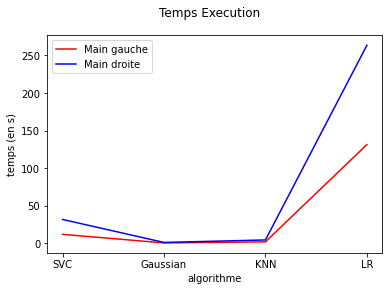

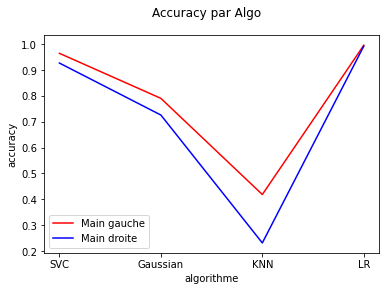

In [21]:
time_l = [svc_l_time, gnb_l_time, knn_l_time, lr_l_time]
time_r = [svc_r_time, gnb_r_time, knn_r_time, lr_r_time]

score_l = [svc_l_score, gnb_l_score, knn_l_score, lr_l_score]
score_r = [svc_r_score, gnb_r_score, knn_r_score, lr_r_score]

algo = ['SVC', 'Gaussian','KNN', 'LR']

fig = plt.figure()
fig.suptitle('Temps Execution')
plt.plot(algo, time_l, 'r', label='Main gauche')
plt.plot(algo, time_r, 'b', label='Main droite')
plt.xlabel('algorithme')
plt.ylabel('temps (en s)')
plt.legend()
plt.show()

fig = plt.figure()
fig.suptitle('Accuracy par Algo')
plt.plot(algo, score_l, 'r', label='Main gauche')
plt.plot(algo, score_r, 'b', label='Main droite')
plt.xlabel('algorithme')
plt.ylabel('accuracy')
plt.legend()
plt.show()

### Explication
On peut voir que la regression logistique est presque parfaite sur le jeu de test de la main approprié mais est très longue d'entrainement<br>
Cependant dès que l'on teste avec les données de l'autre main les résultats sont catastrophique pour tous les modèles (fonctions) : accuracy proche de 0<br>
Le Knn avec le bon nombre de classe n'est pas très précis et le Gaussian est de loin le plus rapide (presque automatique) pour un résultat correct<br>
Le Svc est un peu moins précis que la regression logistique mais beaucoup plus rapide <br>
On peut donc dire que le Gaussian est le plus avantageux aux niveaux du temps et de l'accuracy.